In [1]:
import sys
import os
import hydra
from omegaconf import OmegaConf

# add parent directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

# initialize hydra

In [2]:
hydra.initialize(config_path="../config", version_base="1.1")

# Choose which config to load
config_name = "config"  # Change this to use a different config
print(f"Loading config: {config_name}")

# Load the config
cfg = hydra.compose(
    config_name=config_name, 
    overrides=["experiment=ops_small"]
)

# Display the loaded config
print(OmegaConf.to_yaml(cfg))

Loading config: config
dataset:
  _target_: datasets.ops.OPSDataset
  set_size: ${experiment.set_size}
  seed: ${seed}
  data_shape:
  - 2
  - 64
  - 64
  prob_spatial: ${experiment.spatial_prob}
  spatial_kernel_width: 10
  replace: true
  pert_embedding_dim: ${experiment.pert_embedding_dim}
encoder:
  _target_: encoder.conv_gnn.ConvDistributionEncoder
  in_channels: ${dataset.data_shape[0]}
  hidden_channels: 32
  out_channels: 32
  hidden_dim: ${experiment.hidden_dim}
  latent_dim: ${experiment.latent_dim}
  num_layers: 2
  kernel_size: 3
  height: ${dataset.data_shape[1]}
  width: ${dataset.data_shape[2]}
  pool_type: mean
  agg_type: mean
model:
  _target_: model.unet_large.ContextUnetLarge
  in_channels: ${dataset.data_shape[0]}
  n_feat: 384
  latent_dim: ${experiment.latent_dim}
  image_size: ${dataset.data_shape[1]}
generator:
  _target_: generator.ddpm.DDPM
  model: ${model}
  betas:
  - 0.0001
  - 0.02
  n_T: 400
  drop_prob: 0.1
  noise_shape: ${dataset.data_shape}
optimize

In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'ops_c66c5547594b6499ce918c9be2faac34' in c['name'] 
]   


In [4]:
cfgs

[{'name': 'ops_c66c5547594b6499ce918c9be2faac34',
  'dir': '../outputs/ops_c66c5547594b6499ce918c9be2faac34',
  'config': {'dataset': {'_target_': 'datasets.ops.OPSDataset', 'set_size': '${experiment.set_size}', 'seed': '${seed}', 'data_shape': [2, 64, 64], 'prob_spatial': '${experiment.spatial_prob}', 'spatial_kernel_width': 10, 'replace': True, 'pert_embedding_dim': '${experiment.pert_embedding_dim}'}, 'encoder': {'_target_': 'encoder.conv_gnn.ConvDistributionEncoder', 'in_channels': '${dataset.data_shape[0]}', 'hidden_channels': 32, 'out_channels': 32, 'hidden_dim': '${experiment.hidden_dim}', 'latent_dim': '${experiment.latent_dim}', 'num_layers': 2, 'kernel_size': 3, 'height': '${dataset.data_shape[1]}', 'width': '${dataset.data_shape[2]}', 'pool_type': 'mean', 'agg_type': 'mean'}, 'model': {'_target_': 'model.unet_large.ContextUnetLarge', 'in_channels': 2, 'n_feat': 384, 'latent_dim': 128, 'image_size': 64}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'b

In [5]:
! ls ../outputs/ops_c66c5547594b6499ce918c9be2faac34

checkpoint_epoch_1.pt  checkpoint_epoch_3.pt  checkpoint_epoch_5.pt
checkpoint_epoch_2.pt  checkpoint_epoch_4.pt  config.yaml


In [6]:
import torch
import hydra

def instantiate_and_load_model(config) -> torch.nn.Module:
    """
    Instantiate and load a model from a checkpoint file.
    
    Args:
        model_path: The path to the model checkpoint file
        device: The device to load the model on

    Returns:
        The loaded model
    """
    cfg = config['config']
    encoder = hydra.utils.instantiate(cfg.encoder)
    generator = hydra.utils.instantiate(cfg.generator)

    checkpoint = torch.load(config['dir'] + '/checkpoint_epoch_5.pt', map_location=device, weights_only=False)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    generator.model.load_state_dict(checkpoint['generator_state_dict'])
    return encoder, generator

enc, gen = instantiate_and_load_model(cfgs[0])

In [7]:
dataset = hydra.utils.instantiate(cfg.dataset)


Dataset initialized:
Total tiles: 38942
Total images: 20872480
Available perturbations: 4961
Holdout perturbations: {'BIRC5', 'RACGAP1', 'MAD2L1', 'DONSON', 'RRM1', 'UBE2I', 'PCNA', 'RPA1'}


In [8]:
import numpy as np
from tqdm import tqdm
def get_all_images_for_perturbation(dataset, perturbation_name, max_images=None, use_tqdm=False):
    """
    Efficiently retrieves all images for a specified perturbation using memory mapping.
    
    Args:
        dataset: An initialized OPSDataset instance
        perturbation_name: The name of the perturbation to retrieve
        max_images: Maximum number of images to return (None for all)
        
    Returns:
        A numpy array of all images for the perturbation
    """
    # Check if perturbation exists
    if perturbation_name not in dataset.pert_indices and perturbation_name not in dataset.heldout_pert_indices:
        available_perts = list(dataset.pert_indices.keys())
        holdout_perts = list(dataset.heldout_pert_indices.keys())
        raise ValueError(f"Perturbation '{perturbation_name}' not found. Available: {available_perts}\nHoldout: {holdout_perts}")
    
    # Get perturbation data
    if perturbation_name in dataset.pert_indices:
        pert_data = dataset.pert_indices[perturbation_name]
    else:
        pert_data = dataset.heldout_pert_indices[perturbation_name]
    
    # Collect images from all tiles
    all_images = []
    image_count = 0
    
    if use_tqdm:
        tile_iter = tqdm(pert_data)
    else:
        tile_iter = pert_data
    for tile_data in tile_iter:
        tile_idx = tile_data['tile_idx']
        local_indices = np.array(tile_data['local_indices'])
        
        # Use memory mapping to only load relevant indices
        tile_path = dataset.tile_paths[tile_idx]
        # Memory-map the file
        mmap_array = np.load(f"{tile_path}/single_cell_images.npy", mmap_mode='r')
        # Only extract the indices we need
        perturbation_images = mmap_array[local_indices]
        all_images.append(perturbation_images)
        
        image_count += len(perturbation_images)
        if max_images is not None and image_count >= max_images:
            # Trim to max_images if specified
            all_combined = np.vstack(all_images)
            return all_combined[:max_images]
    
    # Combine all images
    return np.vstack(all_images)

In [139]:
gene_labels = [
    "UBE2I", "DTL", "LRR1", "DONSON", "RRM1", "ORC1", "SMU1", "RPA1", "PCNA", "MMS22L",
    "DDB1", "POLE", "SF3B3", "PSMA4", "RBX1", "CDC45", "PSMB2", "PSMA1", "SNU13",
    "HINFP", "BIRC5", "CRNKL1", "AURKB", "RACGAP1", "PRC1", "MAD2L1", "TTK", "MTBP",
    "ESPL1"
]


In [14]:
# load all data from image tiles


In [13]:
# get all images for perturbation
# load all perturbations in gene_labels
# shuffled_pert_names = np.random.permutation(list(dataset.pert_indices.keys()))
pert_images = {}
for pert in gene_labels + ['nontargeting']:
    pert_images[pert] = get_all_images_for_perturbation(dataset, pert, use_tqdm=True)




100%|██████████| 38196/38196 [03:00<00:00, 211.76it/s]


In [18]:
enc.to('cuda')
gen.model.to('cuda')


ContextUnetLarge(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(2, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 384, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 384, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 384, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 384, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
      )
      (1): MaxPool2d(kerne

In [10]:
from tqdm import tqdm
from collections import defaultdict

# select random subset of tile paths
tile_paths = dataset.metadata['tile_paths']
tile_idxs = np.random.permutation(len(tile_paths))[:20_000]

images_by_pert = defaultdict(list)

tile_to_pert_idx = {}
for k in dataset.metadata['pert_indices']:
    for i in range(len(dataset.metadata['pert_indices'][k])):
        tile_idx = dataset.metadata['pert_indices'][k][i]['tile_idx']
        if tile_idx not in tile_to_pert_idx:
            tile_to_pert_idx[tile_idx] = {}
        tile_to_pert_idx[tile_idx][k] = dataset.metadata['pert_indices'][k][i]['local_indices']


# load all images
for tile_idx in tqdm(tile_idxs):
    imgs = np.load(f"{tile_paths[tile_idx]}/single_cell_images.npy")
    for pert in tile_to_pert_idx[tile_idx]:
        images_by_pert[pert].append(imgs[tile_to_pert_idx[tile_idx][pert]])

for pert in images_by_pert:
    images_by_pert[pert] = np.vstack(images_by_pert[pert])



100%|██████████| 20000/20000 [07:02<00:00, 47.33it/s]


In [123]:
# import gc and clear memory
import gc
# del imgs, img_lats, img_recs
gc.collect()
torch.cuda.empty_cache()

In [124]:
# preprocess tiff
img_lats = {}
img_recs = {}
for pert in images_by_pert:
    imgs = images_by_pert[pert][:, :, 20:-20, 20:-20][None, ...]
    imgs = imgs / 65535
    imgs = 2 * imgs - 1
    imgs = imgs.astype(np.float32)
    if imgs.shape[1] > 1_000:
        imgs = imgs[:, :1_000]
    imgs = torch.tensor(imgs, dtype=torch.float).to('cuda')
    img_lats[pert] = enc(imgs).detach().cpu().numpy()

100%|██████████| 5050/5050 [09:03<00:00,  9.29it/s] 


In [140]:
# lat = enc(imgs)
recons_by_pert = {}
for pert in tqdm(gene_labels):
    rec = gen.sample(torch.tensor(img_lats[pert], dtype=torch.float).to('cuda'), num_samples=100)
    recons_by_pert[pert] = rec.detach().cpu().numpy()

  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:34<16:09, 34.62s/it]

  7%|▋         | 2/29 [01:09<15:35, 34.65s/it]

 10%|█         | 3/29 [01:43<15:00, 34.65s/it]

 14%|█▍        | 4/29 [02:18<14:25, 34.63s/it]

 17%|█▋        | 5/29 [02:53<13:50, 34.61s/it]

 21%|██        | 6/29 [03:27<13:15, 34.60s/it]

 24%|██▍       | 7/29 [04:02<12:40, 34.58s/it]

 28%|██▊       | 8/29 [04:36<12:05, 34.56s/it]

 31%|███       | 9/29 [05:11<11:30, 34.54s/it]

 34%|███▍      | 10/29 [05:45<10:56, 34.54s/it]

 38%|███▊      | 11/29 [06:20<10:21, 34.53s/it]

 41%|████▏     | 12/29 [06:54<09:46, 34.51s/it]

 45%|████▍     | 13/29 [07:29<09:12, 34.51s/it]

 48%|████▊     | 14/29 [08:03<08:37, 34.50s/it]

 52%|█████▏    | 15/29 [08:38<08:03, 34.50s/it]

 55%|█████▌    | 16/29 [09:12<07:28, 34.49s/it]

 59%|█████▊    | 17/29 [09:47<06:53, 34.49s/it]

 62%|██████▏   | 18/29 [10:21<06:19, 34.49s/it]

 66%|██████▌   | 19/29 [10:56<05:44, 34.49s/it]

 69%|██████▉   | 20/29 [11:30<05:10, 34.49s/it]

 72%|███████▏  | 21/29 [12:05<04:35, 34.49s/it]

 76%|███████▌  | 22/29 [12:39<04:01, 34.49s/it]

 79%|███████▉  | 23/29 [13:14<03:26, 34.48s/it]

 83%|████████▎ | 24/29 [13:48<02:52, 34.48s/it]

 86%|████████▌ | 25/29 [14:23<02:17, 34.49s/it]

 90%|████████▉ | 26/29 [14:57<01:43, 34.49s/it]

 93%|█████████▎| 27/29 [15:32<01:08, 34.49s/it]

 97%|█████████▋| 28/29 [16:06<00:34, 34.49s/it]

100%|██████████| 29/29 [16:41<00:00, 34.52s/it]


In [141]:
import torch
import matplotlib.pyplot as plt

def fast_batch_edge_widths(images, threshold=-0.9):
    """
    images: Tensor of shape [B, C, H, W] or [B, H, W]
    Returns: Tensor of shape [B, 4] containing (top, bottom, left, right) widths
    """
    if images.dim() == 4:
        images = images.mean(dim=1)  # [B, C, H, W] -> [B, H, W]
    B, H, W = images.shape

    def edge_width_along_axis(imgs, dim):
        """
        imgs: [B, H] or [B, W]
        dim: 1 if vertical (for rows), 2 if horizontal (for cols)
        """
        mask = imgs > threshold  # [B, L]
        flipped_mask = torch.flip(mask, dims=[1])
        idx_first = mask.float().argmax(dim=1)  # first row/col where mask is True
        idx_last = flipped_mask.float().argmax(dim=1)  # same from opposite side
        width_first = idx_first
        width_last = imgs.shape[1] - idx_last - 1
        return width_first, width_last

    # row means (vertical sweep for top/bottom)
    row_means = images.mean(dim=2)  # [B, H]
    top, bottom = edge_width_along_axis(row_means, dim=1)

    # column means (horizontal sweep for left/right)
    col_means = images.mean(dim=1)  # [B, W]
    left, right = edge_width_along_axis(col_means, dim=1)

    return torch.stack([torch.maximum(top, 64 - bottom), torch.maximum(left, 64 - right)], dim=1)  # [B, 4]

def apply_border_mask_vectorized(images, edge_widths, fill_value=-1.0):
    """
    images: Tensor of shape [B, C, H, W]
    edge_widths: Tensor of shape [B, 2] → (top_height, left_width), symmetric
    fill_value: scalar to set at border
    Returns: masked images [B, C, H, W]
    """
    B, C, H, W = images.shape
    device = images.device

    # Compute full border masks for each image in batch
    rows = torch.arange(H, device=device).view(1, 1, H, 1)  # [1, 1, H, 1]
    cols = torch.arange(W, device=device).view(1, 1, 1, W)  # [1, 1, 1, W]

    top = edge_widths[:, 0].view(B, 1, 1, 1)                # [B, 1, 1, 1]
    left = edge_widths[:, 1].view(B, 1, 1, 1)               # [B, 1, 1, 1]

    # Symmetric masks: True where pixel is in the padded border region
    border_mask = (
        (rows < top) | (rows >= (H - top)) |
        (cols < left) | (cols >= (W - left))
    )  # [B, 1, H, W]

    return torch.where(border_mask, torch.tensor(fill_value, dtype=images.dtype, device=device), images)


def show_real_and_generated_grid(real, generated, N=5, cmap='viridis'):
    """
    real: [B, 2, H, W] tensor of real images
    generated: [B, 2, H, W] tensor of generated images
    Displays a 4-row grid:
        Row 1: real, channel 0
        Row 2: real, channel 1
        Row 3: generated, channel 0
        Row 4: generated, channel 1
    """
    assert real.shape[1] == 2 and generated.shape[1] == 2, "Both must have 2 channels"
    B, _, H, W = real.shape
    N = min(N, B)

    fig, axs = plt.subplots(4, N, figsize=(N * 2.5, 10))

    for i in range(N):
        for row, source, label in zip(
            range(4),
            [real, real, generated, generated],
            ['Real Ch 0', 'Real Ch 1', 'Gen Ch 0', 'Gen Ch 1']
        ):
            img = source[i, row % 2].detach().cpu().numpy()
            ax = axs[row, i]
            ax.imshow(img, cmap=cmap)
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(label, fontsize=12)

    plt.tight_layout()
    plt.show()


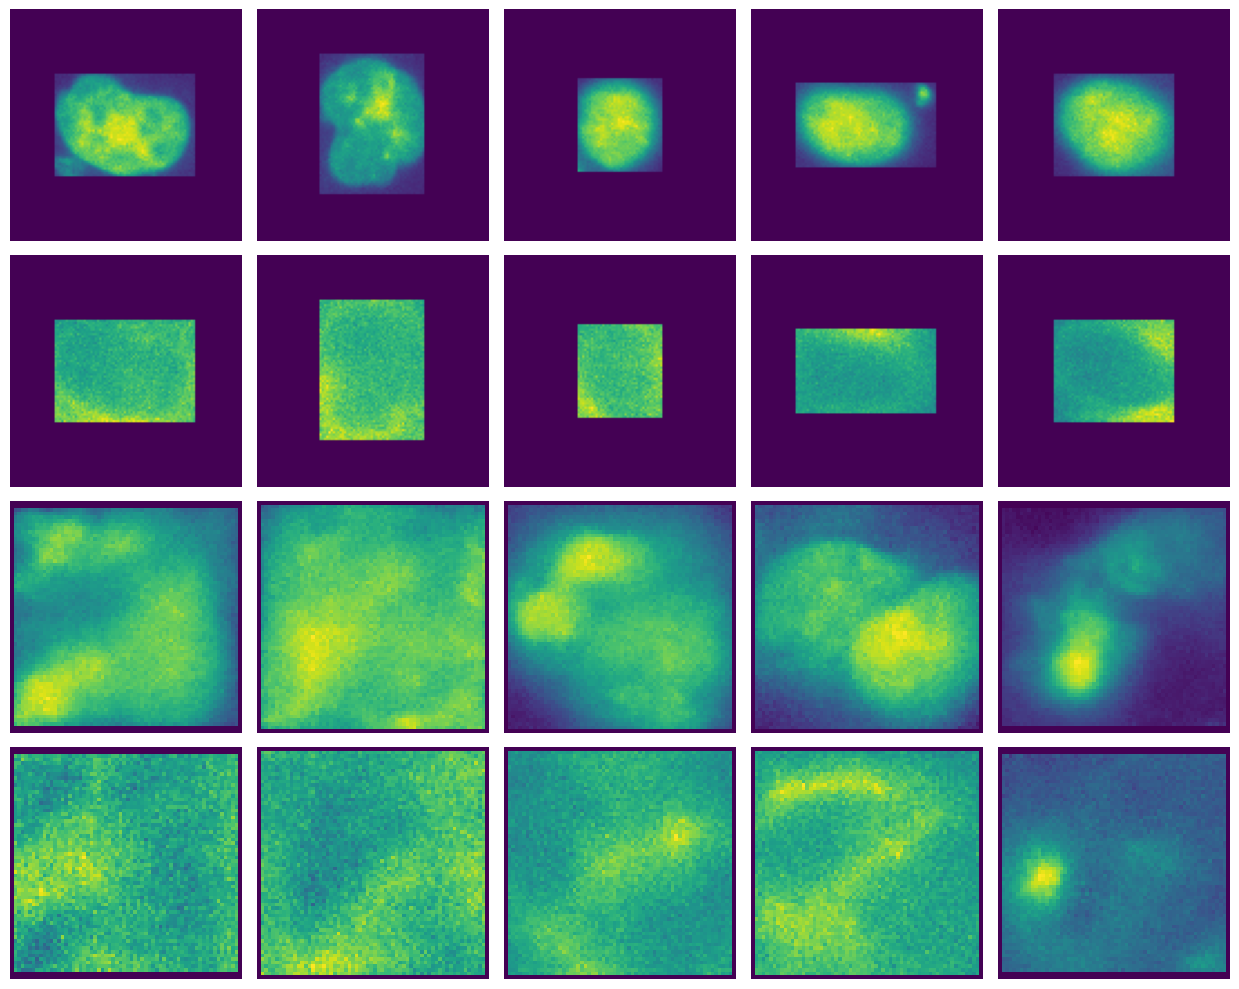

In [160]:
pert_image = torch.tensor(images_by_pert[pert])
pert_recon = torch.tensor(recons_by_pert[pert][0][:40])
pert_recon = apply_border_mask_vectorized(pert_recon, fast_batch_edge_widths(pert_recon))

show_real_and_generated_grid(pert_image, pert_recon)


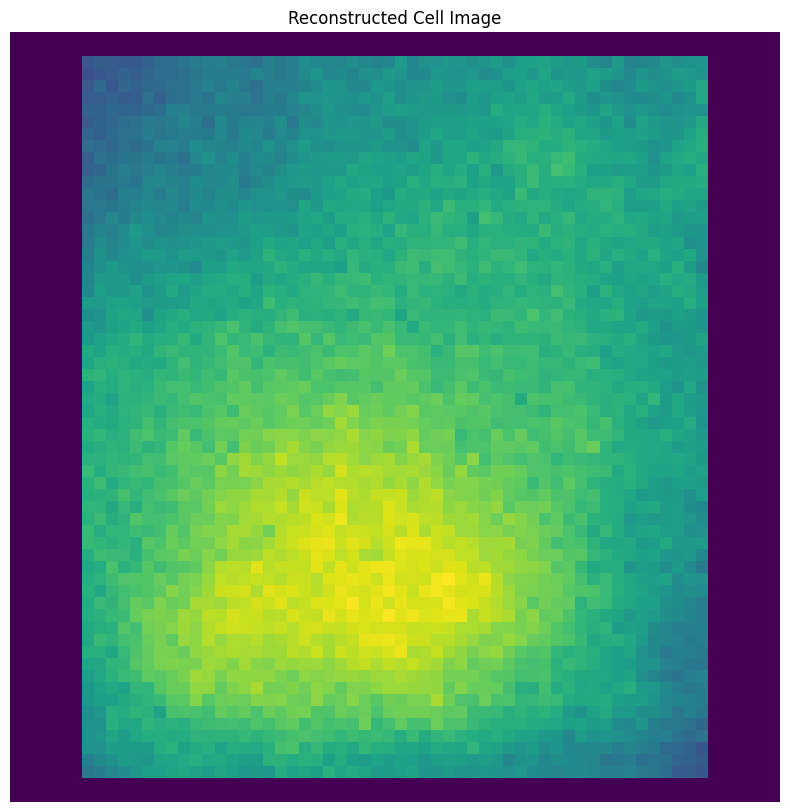

In [43]:
# show image 
import matplotlib.pyplot as plt

# Get first image from reconstructions
img = rec_bordered[, 0].detach().cpu().numpy()
# img = pert_images['UBE2I'][0][0]

# Create figure and display image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Reconstructed Cell Image')
plt.show()

In [161]:
nucleus_size = {}
for pert in gene_labels + ['nontargeting']:
    nucleus_size[pert] = images_by_pert[pert][:, 0][20:-20, 20:-20].mean()
    print(pert, nucleus_size[pert])

UBE2I 1747.501466895195
DTL 2076.529079842966
LRR1 1810.3307516248583
DONSON 1556.174740161181
RRM1 1575.689788645331
ORC1 1634.4019917125386
SMU1 1714.1093071831597
RPA1 1632.4416498671712
PCNA 1605.2771424825175
MMS22L 1667.6783885228654
DDB1 1569.9617877435064
POLE 1541.7136634548192
SF3B3 1485.8085842198263
PSMA4 1578.1125237107767
RBX1 1589.5473707872763
CDC45 1488.5723679489697
PSMB2 1505.4151719487852
PSMA1 1448.9985186890158
SNU13 1565.664991799379
HINFP 1481.9406235400538
BIRC5 1711.3317716949268
CRNKL1 1566.9788993430745
AURKB 1674.4884913879828
RACGAP1 1581.1462445502866
PRC1 1584.8532194879153
MAD2L1 1519.5927250724446
TTK 1488.4140336076184
MTBP 1501.6061458396575
ESPL1 1589.2604669535667
nontargeting 1391.9860601223677
